## Lecture 7 - LU Factorization and Banded Matrices (Chapter 8 - McClarren)

I don't plan to lecture over much of the detail in this Chapter, aside from talking about the why. 

There may be important applications where we might need to solve many linear systems where the matrix is the same, but the right hand side matrix is different.  It would be a shame to have to redo the Gaussian Elimination every time the RHS vector changes. 

The basic idea of LU factorization is to write a matrix $A$ as

$$A = LU,$$

where $L$ is a lower triangular matrix, and $U$ is an upper triangular matrix:

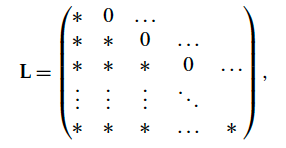

and

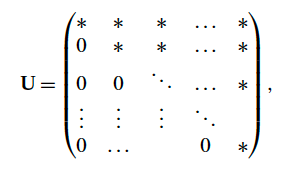

We can get $L$ and $U$ from a Gaussian Elimination:

1. The upper triangular matrix is the same as the matrix we received after doing Gaussian elimination.
2. The non-zero and non-diagonal elements of the lower triangular matrix are the factors we used to arrive at our Gaussian matrix.

This suggests that we can reformulate our Gaussian elimination example to give us an LU factorization. What we will have to do is

1. Store the factors used to eliminate matrix elements in the appropriate place to get the L matrix, and
2. Perform Gaussian elimination as usual.

Then, we can use the stored $L$ and $U$ matrices to obtain the solution vector for any RHS vector, via:

$Ly = b$

and

$Ux = y$.

## Banded and Symmetrix Matrices

For a matrix to be __symmetric__ it means that if I transpose the matrix, the matrix does not
change, i.e. if,

$$A_{ij} = A_{ji}$$


Banded matrices take their name from the structure of the matrix. When the non-zeros of
the matrix are shown they form bands around the diagonal. A diagonal matrix is a banded
matrix of bandwith 1:

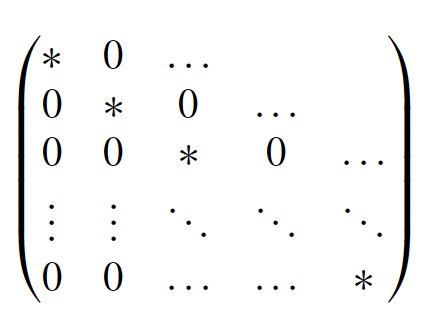

A common banded matrix is the tridiagonal matrix:

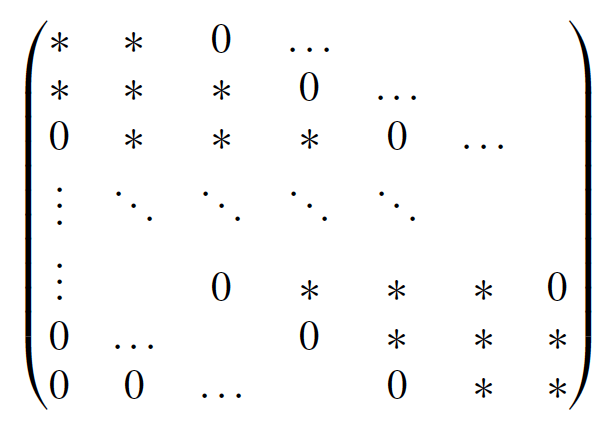

Banded matrices are easier to solve, and easier to store, since we don't need to store any of the zeros outside the banded structure.  

Pretty much, that's all I want you to take away from Chapter 8.  :-)


## Iterative Methods for Linear Systems - (Chapter 9, McClarren)

We've been looking at direct methods so far.  They are direct because the amount of work required to get the answer to the linear system is fixed based on the size of the problem.  The computational cost also doesn't really depend on the details of the matrix problem at all (except if you include pivoting...).

There are other techniques that are iterative in nature - guess at the solution and refine that guess until we are "close enough".  Most of the methods in this family require diagonal dominance for them to work.  Diagonal dominance means that for each row $i$ in the matrix $A$ of size $I$ by $I$,

$$ \left| A_{ii} \right| > \sum\limits_{j=1,j\ne i} ^{I} A_{ij}, \qquad i=1 \cdots I $$

### Jacobi Iteration

Take the system $A x= b$ and split it into two parts: one that acts on the new guess, and one that acts on the old guess:

$$ A_{ii} x_i^{(l+1)} = b_i - \sum\limits_{j=1,j\ne i} ^{I} A_{ij} x_j^{(l)} , \qquad i=1 \cdots I, l=0 \cdots $$

When do we stop?  We'll stop when

$$\frac{|| x^{(l+1)} - x^{(l)}||_2}{|| x^{(l+1)}||_2} < \varepsilon $$

where $\varepsilon$ is a user defined tolerance, and the "2-norm" is 

$$ || y||_2 = \sqrt{\sum\limits_{i=1}^I y_i^2} $$

In [1]:
import numpy as np
A = np.array([(2.5,-1,0,0),(-1,2.5,-1,0),(0,-1,2.5,-1),(0,0,-1,2.5)])
print("Our matrix is\n",A)
b = np.array([1.0,1,1,1])
x = np.array([0,0.5,0.5,0])
print("Our RHS is",b)
print("The initial guess is",x)

Our matrix is
 [[ 2.5 -1.   0.   0. ]
 [-1.   2.5 -1.   0. ]
 [ 0.  -1.   2.5 -1. ]
 [ 0.   0.  -1.   2.5]]
Our RHS is [1. 1. 1. 1.]
The initial guess is [0.  0.5 0.5 0. ]


In [2]:
#first Jacobi iteration
x_new = np.zeros(4)
for row in range(4):
    x_new[row] = b[row]
    for column in range(4):
        if column != row:
            x_new[row] -= A[row,column]*x[column]
    x_new[row] /= A[row,row]  # important to put this at the right spot in the indention...
#check difference
relative_change = np.linalg.norm(x_new-x)/np.linalg.norm(x_new)
print("New guess is",x_new)
print("Norm of change is",relative_change)

New guess is [0.6 0.6 0.6 0.6]
Norm of change is 0.7168604389202189


In [3]:
x = x_new.copy() #replace old value
x_new *= 0 #reset x_new
for row in range(4):
    x_new[row] = b[row]
    for column in range(4):
        if column != row:
            x_new[row] -= A[row,column]*x[column]
    x_new[row] /= A[row,row]
#check difference
relative_change = np.linalg.norm(x_new-x)/np.linalg.norm(x_new)
print("New guess is",x_new)
print("Norm of change is",relative_change)

New guess is [0.64 0.88 0.88 0.64]
Norm of change is 0.2599376224550183


One more iteration...

In [4]:
#Third Jacobi Iteration
x = x_new.copy() #replace old value
x_new *= 0 #reset x_new
for row in range(4):
    x_new[row] = b[row]
    for column in range(4):
        if column != row:
            x_new[row] -= A[row,column]*x[column]
    x_new[row] /= A[row,row]
#check difference
relative_change = np.linalg.norm(x_new-x)/np.linalg.norm(x_new)
print("New guess is",x_new)
print("Norm of change is",relative_change)

New guess is [0.752 1.008 1.008 0.752]
Norm of change is 0.1352431475798435


Here is a nicely formatted way of expressing this algorithm using LaTeX's `algorithm` environment:

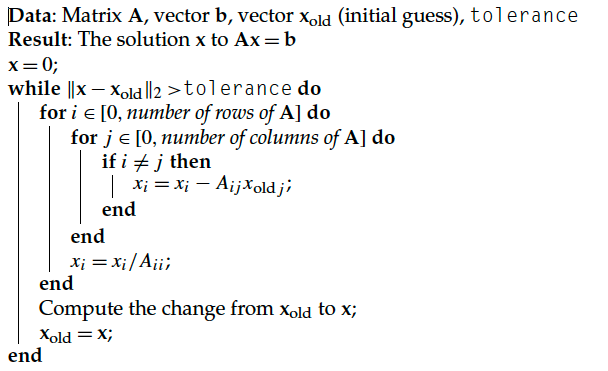

In [5]:
def JacobiSolve(A,b,x0=np.array([]),tol=1.0e-6,
                max_iterations=100,LOUD=False,):
    '''Solve a linear system by Jacobi iteration.
    Note: system must be diagonally dominant
    Args:
        A: N by N array
        b: array of length N
        x0: initial guess (if none given will be random)
        tol: Relative L2 norm tolerance for convergence
        max_iterations: maximum number of iterations
    Returns:
        The approximate solution to the linear system
    '''
    [Nrow, Ncol] = A.shape
    assert Nrow == Ncol
    N = Nrow
    converged = False
    iteration = 1
    if (x0.size==0):
        #random initial guess
        x0 = np.random.rand(N)
    x = x0.copy()
    while not(converged):
        #replace old value
        x0 = x.copy()
        for row in range(N):
            x[row] = b[row]
            for column in range(N):
                if column != row:
                    x[row] -= A[row,column]*x0[column]
            x[row] /= A[row,row]
        relative_change = np.linalg.norm(x-x0)/np.linalg.norm(x)
        if (LOUD):
            print("Iteration",iteration,
                  ": Relative Change =",relative_change)
        if (relative_change < tol) or (iteration >= max_iterations):
            converged = True
        iteration += 1
    return x

Let's use this function in an example: a 4x4 matrix...

In [7]:
A = np.array([(2.3,-1,0,0),(-1,2.3,-1,0),(0,-1,2.3,-1),(0,0,-1,2.3)])
print("Our matrix is\n",A)
b = np.array([1.0,1,1,1])
x = JacobiSolve(A,b,tol=1.0e-6,LOUD=True)
print(x)

Our matrix is
 [[ 2.3 -1.   0.   0. ]
 [-1.   2.3 -1.   0. ]
 [ 0.  -1.   2.3 -1. ]
 [ 0.   0.  -1.   2.3]]
Iteration 1 : Relative Change = 0.5010217417464915
Iteration 2 : Relative Change = 0.2633189077007922
Iteration 3 : Relative Change = 0.1607018576293662
Iteration 4 : Relative Change = 0.10379651783081233
Iteration 5 : Relative Change = 0.06909338923831379
Iteration 6 : Relative Change = 0.04683690662673005
Iteration 7 : Relative Change = 0.032126612556983576
Iteration 8 : Relative Change = 0.022210468551660124
Iteration 9 : Relative Change = 0.015437271527889535
Iteration 10 : Relative Change = 0.010769011357911045
Iteration 11 : Relative Change = 0.007531519501564071
Iteration 12 : Relative Change = 0.0052766113535155776
Iteration 13 : Relative Change = 0.0037013644566235345
Iteration 14 : Relative Change = 0.0025986168245806358
Iteration 15 : Relative Change = 0.0018255109125244087
Iteration 16 : Relative Change = 0.0012829515691519893
Iteration 17 : Relative Change = 0.000901

In [8]:
#Check the answer
print("Ax =",np.dot(A,x))
print("b =",b)

Ax = [0.99999979 0.9999969  0.99999966 0.99999808]
b = [1. 1. 1. 1.]


We can do something bigger, too!

In [9]:
N = 100
A = np.zeros((N,N))
b = np.ones(N)
#same structure as before
for i in range(N):
    A[i,i] = 2.5
    if (i>0):
        A[i,i-1] = -1
    if (i < N-1):
        A[i,i+1] = -1
x100 = JacobiSolve(A,b,tol=1.0e-6,LOUD=True)
print(x100)

Iteration 1 : Relative Change = 0.5574911500909199
Iteration 2 : Relative Change = 0.3108686113497308
Iteration 3 : Relative Change = 0.20060811552902347
Iteration 4 : Relative Change = 0.1384144654107989
Iteration 5 : Relative Change = 0.09948151846322642
Iteration 6 : Relative Change = 0.07345248069550792
Iteration 7 : Relative Change = 0.05525996342555712
Iteration 8 : Relative Change = 0.04213662375019182
Iteration 9 : Relative Change = 0.03245080485306695
Iteration 10 : Relative Change = 0.025178909903895513
Iteration 11 : Relative Change = 0.019648625188955982
Iteration 12 : Relative Change = 0.015401000093718328
Iteration 13 : Relative Change = 0.012113506014822516
Iteration 14 : Relative Change = 0.009553805526736537
Iteration 15 : Relative Change = 0.007551365324688787
Iteration 16 : Relative Change = 0.005978984700986361
Iteration 17 : Relative Change = 0.004740617809352337
Iteration 18 : Relative Change = 0.003762975128046836
Iteration 19 : Relative Change = 0.00298968170354

### Convergence of the Jacobi Method...

Let's look at a 2x2 and make a plot of how the soution is changing with each iteration.  Here's the example problem:

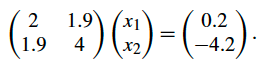

The answer is $x_1 = 2$ and $x_2 = -2$.  We'll start with an initial guess of $x^{(0)} = (-1,0.5)^{T}$.

In [10]:
def JacobiSolve(A,b,x0=np.array([]),tol=1.0e-6,
                max_iterations=100,LOUD=False,):
    '''Solve a linear system by Jacobi iteration.
    Note: system must be diagonally dominant
    Args:
        A: N by N array
        b: array of length N
        x0: initial guess (if none given will be random)
        tol: Relative L2 norm tolerance for convergence
        max_iterations: maximum number of iterations
    Returns:
        The approximate solution to the linear system
    '''
    [Nrow, Ncol] = A.shape
    assert Nrow == Ncol
    N = Nrow
    converged = False
    iteration = 1
    if (x0.size==0):
        #random initial guess
        x0 = np.random.rand(N)
    x = x0.copy()
    while not(converged):
        #replace old value
        x0 = x.copy()
        for row in range(N):
            x[row] = b[row]
            for column in range(N):
                if column != row:
                    x[row] -= A[row,column]*x0[column]
            x[row] /= A[row,row]
        relative_change = np.linalg.norm(x-x0)/np.linalg.norm(x)
        if (LOUD):
            print("Iteration",iteration,
                  ": Relative Change =",relative_change)
        if (relative_change < tol) or (iteration >= max_iterations):
            converged = True
        iteration += 1
        solution = np.array([])
        solution
    return x

Iteration 1 : Relative Change = 1.4269664160236233
Iteration 2 : Relative Change = 3.667381504310245
Iteration 3 : Relative Change = 0.8774931574566182
Iteration 4 : Relative Change = 0.6117084441678874
Iteration 5 : Relative Change = 0.26095084981810923
Iteration 6 : Relative Change = 0.21229535544915268
Iteration 7 : Relative Change = 0.09935505062559573
Iteration 8 : Relative Change = 0.08671074869860534
Iteration 9 : Relative Change = 0.04177783586917181
Iteration 10 : Relative Change = 0.03751937344044419
Iteration 11 : Relative Change = 0.0182829003009511
Iteration 12 : Relative Change = 0.01662200267413072
Iteration 13 : Relative Change = 0.008138698485033069
Iteration 14 : Relative Change = 0.007439468351937333
Iteration 15 : Relative Change = 0.0036502872160426897
Iteration 16 : Relative Change = 0.003344741601051041
Iteration 17 : Relative Change = 0.0016426868886015844
Iteration 18 : Relative Change = 0.0015068194743121782
Iteration 19 : Relative Change = 0.00074034833633633

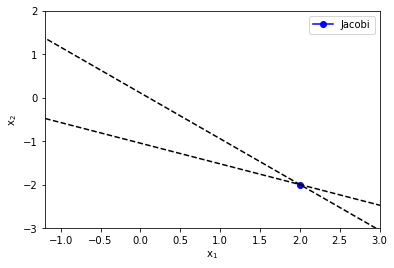

In [11]:
import matplotlib.pyplot as plt 
import numpy as np
A = np.array([(2,1.9),(1.9,4)])
solution = np.ones(2)*2
solution[1] = -2
b = np.dot(A,solution)
x0 = np.array([-1,2.0])
xp, yp = JacobiSolve(A,b,x0=x0, LOUD=True)
plt.plot(xp,yp,'bo-',label='Jacobi')
xpoint = np.linspace(-5,5,100)
line1 = lambda x: (0.2 - 2*x)/1.9
line2 = lambda x: (-4.2 - 1.9*x)/4
plt.plot(xpoint,line1(xpoint),'--', color = 'black')
plt.plot(xpoint,line2(xpoint),'--', color = 'black')
plt.axis([-1.2,3,-3,2])
plt.legend(); plt.xlabel('x$_1$'); plt.ylabel('x$_2$')
plt.show()

So, you'll see that the plot I am making is not the same as the one in McClarren's book, which I have included here:

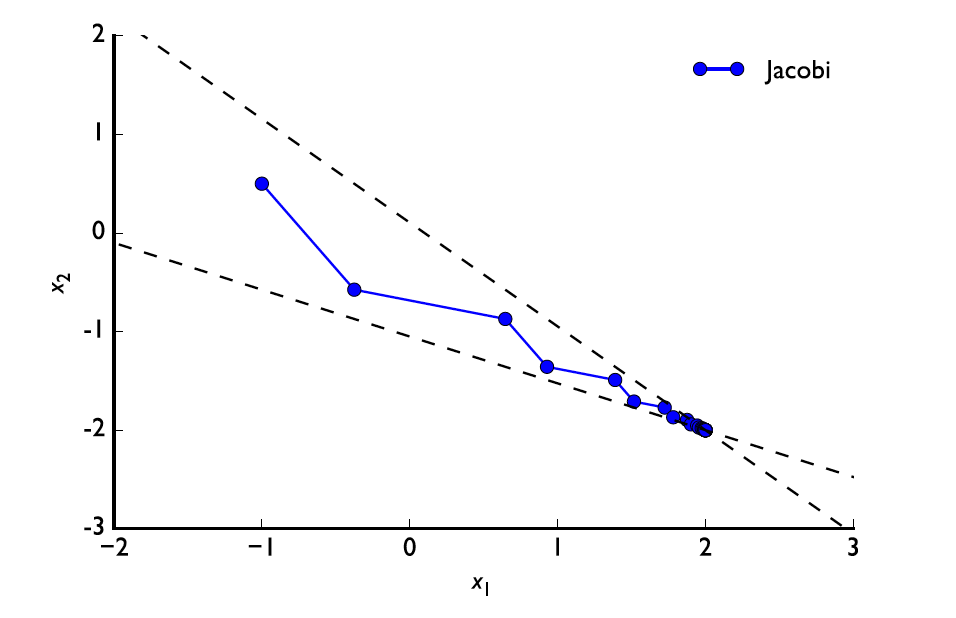

The Jacobi solution bounces around in the area between the two lines. Because the approximation is always in this area and moves toward the solution, it will eventually get to the solution. Also, note that the initial steps are large, and the step size shrinks as the approximate solutions gets closer to the true answer.

## Time to Solution - Jacobi

We can do the same computational efficiency experiment that we did previously with Gaussian Elimination with Jacobi's method.  

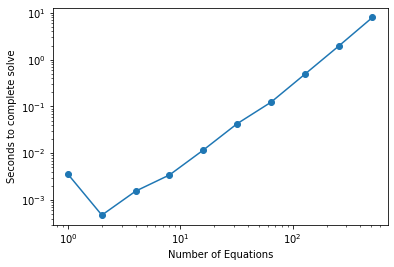

Approximate growth rate is n^ 2.0392924079661885


In [12]:
import time
num_tests = 10
I = 2**np.arange(num_tests)
times = np.zeros(num_tests)
for test in range(num_tests):
    N = I[test]
    A = np.zeros((N,N))
    b = np.ones(N)
    #same structure as before
    for i in range(N):
        A[i,i] = 2.5
        if (i>0):
            A[i,i-1] = -1
        if (i < N-1):
            A[i,i+1] = -1
    start = time.time()
    x = JacobiSolve(A,b)
    end = time.time()
    times[test] = end-start
plt.loglog(I,times,'o-')
plt.xlabel("Number of Equations")
plt.ylabel("Seconds to complete solve")
plt.show()
print("Approximate growth rate is n^",
      (np.log(times[test])-np.log(times[test-1]))/
      (np.log(I[test])-np.log(I[test-1])))

So Jacobi goes as $O(N^2)$, and Gaussian Elimination goes as $O(N^3)$, so at some point Jacobi will be significantly faster than GE.  But, remember Jacobi only works for diagonally dominant linear systems.

We also can't guarantee the number of iterations it will take to converge Jacobi, but we have a definite prescription for the amount of work it takes for GE.  Also, in these estimates of timing, what we really have are $C_1 N^2$ and $C_2 N^3$, and the size of the two constants will play a role in which one is faster.  If $C_1 = 10^6 C_2$, well, you see the point.  


### A Faster Jacobi Method...

We have written Jacobi as:

$$ x_i^{(l+1)} = \frac{1}{A_{ii}} \left( b_i - \sum\limits_{j=1,j\ne i} ^{I} A_{ij} x_i^{(l)}  \right), \qquad i=1 \cdots I, l=0 \cdots $$

but we could add and subtract $A_{ii} x_i^{(l)}$ inside the sum to instead write:

$$ x_i^{(l+1)} = \frac{1}{A_{ii}} \left( b_i - \textbf{a}_{i} \textbf{x}^{(l)} + A_{ii} x_i^{(l)} \right), \qquad i=1 \cdots I, l=0 \cdots $$

where $\textbf{a}_{i}$ is the $i$-th row of matrix $A$, and $\textbf{x}$ is the solution vector.  

Or, we can represent this in terms of matrix vector products via:

$$ \textbf{x}^{(l+1)} = \frac{1}{\texttt{Diag}(A)} \left(\textbf{b} - \textbf{A} \cdot \textbf{x}^{(l)} + \texttt{Diag}(A) \cdot \textbf{x}^{(l)} \right) $$

We can rewrite the algorithm now, without for loops...

In [14]:
def JacobiSolve_Short(A,b,x0=np.array([]),tol=1.0e-6, max_iterations=100,LOUD=False):
    '''Solve a linear system by Jacobi iteration.
    This implementation removes the for loops to make it faster
    Note: system must be diagonally dominant
    Args:
        A: N by N array
        b: array of length N
        tol: Relative L2 norm tolerance for convergence
        max_iterations: maximum number of iterations
    Returns:
        The approximate solution to the linear system
    '''
    [Nrow, Ncol] = A.shape
    assert Nrow == Ncol
    N = Nrow
    converged = False
    iteration = 1
    if (x0.size==0):
        #random initial guess
        x0 = np.random.rand(N)
    x = x0.copy()
    while not(converged):
        x0 = x.copy() #replace old value
        #update is (b - whole row * x + diagonal part * x)/diagonal
        x = (b - np.dot(A,x0)+ A.diagonal()*x0)/A.diagonal()
        relative_change = np.linalg.norm(x-x0)/np.linalg.norm(x)
        if (LOUD):
            print("Iteration", iteration,
                  ": Relative Change =",relative_change)
        if (relative_change < tol) or (iteration >= max_iterations):
            converged = True
        iteration += 1
    return x

In [15]:
N = 100
A = np.zeros((N,N))
b = np.ones(N)
#same structure as before
for i in range(N):
    A[i,i] = 2.5
    if (i>0):
        A[i,i-1] = -1
    if (i < N-1):
        A[i,i+1] = -1
x100_Short = JacobiSolve_Short(A,b,tol=1.0e-6,LOUD=True)
print(x100_Short-x100)

Iteration 1 : Relative Change = 0.580981889561287
Iteration 2 : Relative Change = 0.3028067078573025
Iteration 3 : Relative Change = 0.19102774563952057
Iteration 4 : Relative Change = 0.13032312629484002
Iteration 5 : Relative Change = 0.09307983548547359
Iteration 6 : Relative Change = 0.0684924074707663
Iteration 7 : Relative Change = 0.05144109899842897
Iteration 8 : Relative Change = 0.039200487042010894
Iteration 9 : Relative Change = 0.030191227417145118
Iteration 10 : Relative Change = 0.023436941759645093
Iteration 11 : Relative Change = 0.018302865199244796
Iteration 12 : Relative Change = 0.014359159250643206
Iteration 13 : Relative Change = 0.011305355710661047
Iteration 14 : Relative Change = 0.008925821883384326
Iteration 15 : Relative Change = 0.007062624087120577
Iteration 16 : Relative Change = 0.005598105936998032
Iteration 17 : Relative Change = 0.004443460290585975
Iteration 18 : Relative Change = 0.0035309160522289224
Iteration 19 : Relative Change = 0.002808315686

 n          #### You'll need to take this on faith at this point (or prove it to yourself...), but the *fast Jacobi* is in fact, faster.

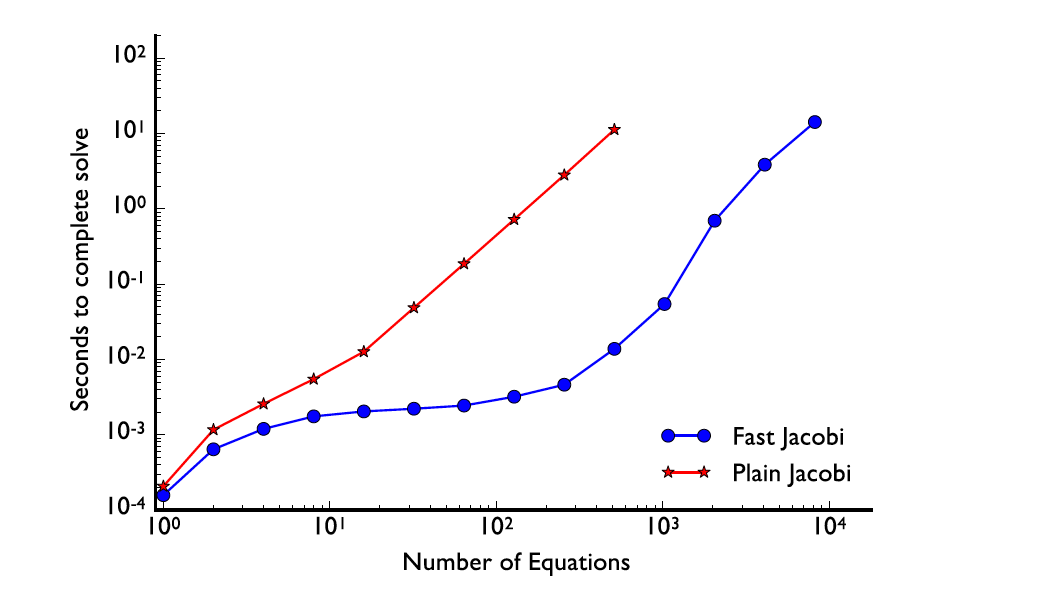

### Gauss Seidel 

The simplest way to understand Gauss Seidel is that, as soon as there is a new updated element of $x$ computed, we use it, rather than always using *old* information in the iteration.  In math, this looks like:

$$ x_i^{(l+1)} = \frac{1}{A_{ii}} \left( b_i - \sum\limits_{j=1}^{i-1} A_{ij} x_i^{(l+1)} - \sum\limits_{j=i+1}^{I} A_{ij} x_i^{(l)}  \right), \qquad i=1 \cdots I, l=0 \cdots $$

In [16]:
def Gauss_Seidel_Solve(A,b,tol=1.0e-6,max_iterations=100,LOUD=False):
    """Solve a linear system by Gauss-Seidel iteration.
    Note: system must be diagonally dominant
    Args:
        A: N by N array
        b: array of length N
        tol: Relative L2 norm tolerance for convergence
        max_iterations: maximum number of iterations
    Returns:
        The approximate solution to the linear system
    """
    [Nrow, Ncol] = A.shape
    assert Nrow == Ncol
    N = Nrow
    converged = False
    iteration = 1
    x = np.random.rand(N) #random initial guess 
    x_new = np.zeros(N)
    while not(converged):
        x = x_new.copy() #replace old value
        for row in range(N):
            x_new[row] = b[row]
            for column in range(N):
                if column != row:
                    #only change from before is that I use x_new in the update
                    x_new[row] -= A[row,column]*x_new[column]
            x_new[row] /= A[row,row]
        relative_change = np.linalg.norm(x_new-x)/np.linalg.norm(x_new)
        if (LOUD):
            print("Iteration",iteration,": Relative Change =",relative_change)
        if (relative_change < tol) or (iteration >= max_iterations):
            converged = True
        iteration += 1
    return x_new

In [17]:
import numpy as np
N = 100
A = np.zeros((N,N))
b = np.ones(N)
#same structure as before
for i in range(N):
    A[i,i] = 2.5
    if (i>0):
        A[i,i-1] = -1
    if (i < N-1):
        A[i,i+1] = -1
x100_GS = Gauss_Seidel_Solve(A,b,LOUD=True)
print(x100_GS)

Iteration 1 : Relative Change = 1.0
Iteration 2 : Relative Change = 0.3986603038884973
Iteration 3 : Relative Change = 0.20923688836146034
Iteration 4 : Relative Change = 0.12200547742918719
Iteration 5 : Relative Change = 0.07497774238647385
Iteration 6 : Relative Change = 0.04745863298732883
Iteration 7 : Relative Change = 0.03057708116415138
Iteration 8 : Relative Change = 0.01991937933195369
Iteration 9 : Relative Change = 0.013068316196330539
Iteration 10 : Relative Change = 0.008612920601712593
Iteration 11 : Relative Change = 0.005693553762661966
Iteration 12 : Relative Change = 0.0037711713183731905
Iteration 13 : Relative Change = 0.002501152663253116
Iteration 14 : Relative Change = 0.0016602953098224403
Iteration 15 : Relative Change = 0.0011027729868139725
Iteration 16 : Relative Change = 0.0007327556220198191
Iteration 17 : Relative Change = 0.000487022353731405
Iteration 18 : Relative Change = 0.00032375625133220003
Iteration 19 : Relative Change = 0.00021524942914177202


So, for this matrix, Gauss Seidel took 33 iterations, and Jacobi took 56 iterations.  Not quite a factor of 2 improvement, but certainly better!

If we observe the convergence behavior from Gauss Seidel using the 2x2 considered earlier, we see:

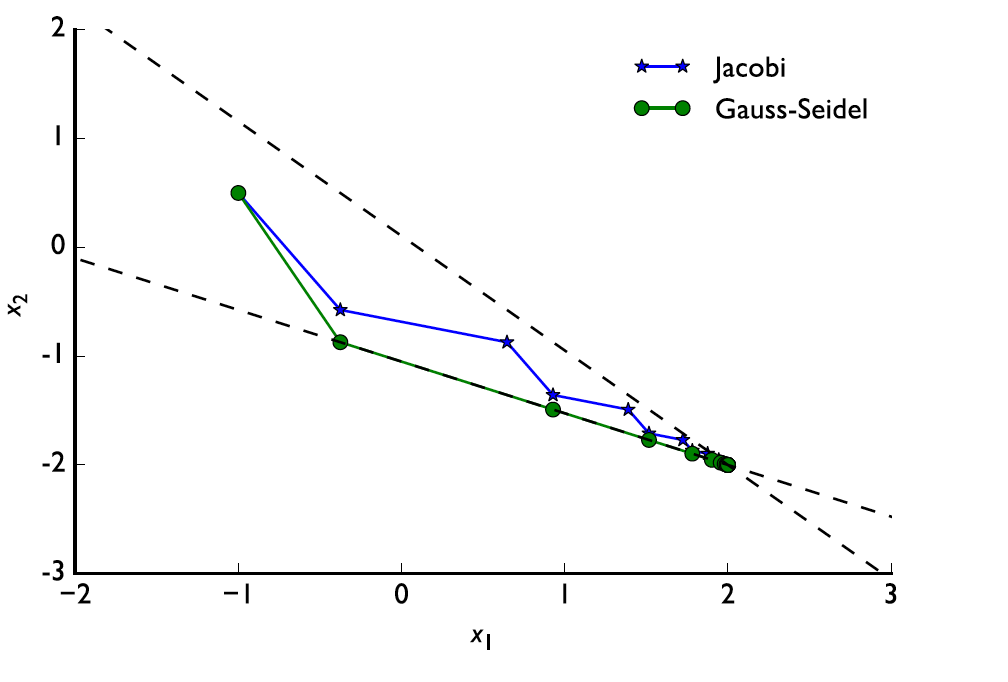

And the timing of Gauss Seidel looks like this, in comparison with Jacobi:

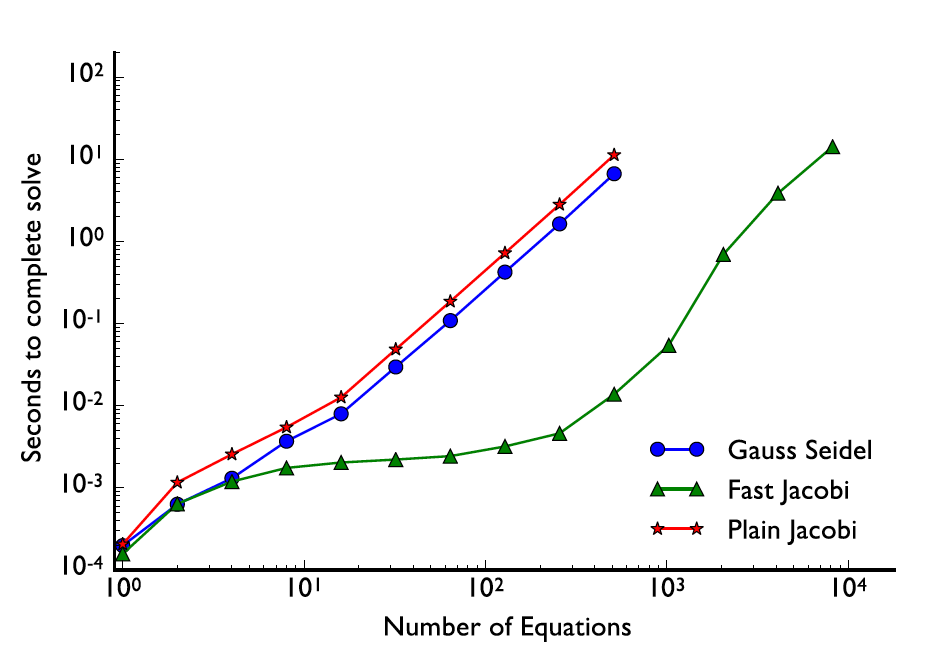

A couple other things to mention:
1. While there are fewer iterations in Gauss Seidel, it is not as computationally cheap as Fast Jacobi.
2. We can't make a Fast Gauss Seidel because done in the same fast manner as Jacobi because while each e

There are three other concepts that are covered in this chapter, and we are going to leave them be: Successive Over Relaxation (SOR), Conjugate Gradient (CG), and algorithms that rely on tridiagonal or banded matrix forms.  